In [1]:
import os ##冰激淋+擔擔麵+蜂蜜檸檬適用

os.environ["CUDA_VISIBLE_DEVICES"] = "0" #使用第0張顯卡 ##冰激淋+擔擔麵+蜂蜜檸檬適用 0or1

In [2]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.3
set_session(tf.Session(config=config))

/opt/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
import keras
from keras import regularizers
from keras import backend as K
from keras.layers import Input, LSTM, Dense, Dropout, Flatten, Convolution1D, MaxPooling1D, Activation, BatchNormalization,\
Lambda, Concatenate, Add, Conv2D, Conv1D,TimeDistributed,MaxPooling2D
from keras.optimizers import Adam
from keras.models import load_model
from keras.callbacks import EarlyStopping
from keras.layers.advanced_activations import PReLU
from keras.models import Model
from keras.layers import Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from itertools import combinations
from itertools import permutations
import matplotlib.pyplot as plt
import psutil
import os
import numpy as np
import pandas as pd
import datetime
import warnings
import pickle
import csv
import random
from keras.models import Sequential
from keras import backend as K



In [4]:
"""
基本設定
"""
#n=148335 #用2016 1~3月的資料 288x(31+29+31+30+31+30+...)=52416 210528-1(all) 差值在減一  
l=144 #區間為12小時
currency = ["SEK","CHF","CAD","GBP","JPY","EUR","AUD"]
#SEK:瑞典克朗  CHF:瑞士法郎 CAD:加拿大幣 GBP:英鎊 
#currency = ["BTC","DASH","ETH","LTC","JBY","GBP","EUR","AUD","US"]
currencynum = len(currency)
month = [0,31,60,91,121,152,182,213,244,274,305,335,366,397,425,456,486,517,547,578,609,639,670,700,731] #2016是閏年 366天
daynum = [0,5802,11745,18351,24380,30579,36861,42795,49201,55342,61230,67400,73732,79984,85726,92343,98127,104692,111028,117076,123700,129807,136083,142401,148335]
question = ["trand","volatility"]
# 貨幣組合，1 : P, 0 : C
M=0
head = 12
tail = 20
epochs = 30
batch_size = 4096
#pl 4  kn 5
pl=8
kn=9
all_cur_pair = list(combinations(currency,2))# (Cn取2) 問題沒有先後順序時使用
if(M==0):
    all_cur_pair_P = list(combinations(currency,2))# (Cn取2) 問題沒有先後順序時使用
elif(M==1):
    all_cur_pair_P = list(permutations(currency,2))# (Pn取2) 問題有先後順序時使用  
all_question= list(permutations(question,1))
np.set_printoptions(suppress=True)#不要用科學符號輸出
lastepoch_train_acc = []
lastepoch_test_acc = []
lastepoch_train_loss = []
lastepoch_test_loss = []
total_test_vol = []
total_test_trend = []
train_length=3 
test_length=1 

In [5]:

"""""""""
str, onehotcode, company code轉換
"""""""""
currencylist = {}
questionlist = {}
for i in range(len(currency)):
    currencylist[i] = currency[i]

for i in range(len(question)):
    questionlist[i] = question[i]

def str_to_currency(cur):
    return {v: k for k, v in currencylist.items()}[cur]

def str_to_question(q):
    return {v: k for k, v in questionlist.items()}[q]


def one_hot_currency(currencylist):
    d = {}
    temp = np.eye((len(currencylist)))
    for i in range(len(currencylist)):
        d[i] = temp[i]
    return d

def one_hot_question(questionlist):
    d = {}
    temp = np.eye((len(questionlist)))
    for i in range(len(questionlist)):
        d[i] = temp[i]
    return d

onehotcurrency = one_hot_currency(currencylist)
onehotquestion = one_hot_question(questionlist)


"""
Q&A
"""
vol='volatility'
def set_question(com1, com2,typeq):
    return np.concatenate((onehotquestion[str_to_question(typeq)],onehotcurrency[str_to_currency(com1)], onehotcurrency[str_to_currency(com2)]))

qtype = ['big']
HVqtype = ['big']

"""比漲幅程度類問題"""
def set_question_and_answer_pair(data, data2, n, all_cur_pair_P): #比較波動率大小的問題
    q_pair = {}
    a_pair = {}
    outcome=np.zeros((currencynum,1))
    for c in range(currencynum):
        data2[c]=data2[c]-data2[c][0]
    #data_sum=np.sum(data,axis=1)
    data2_sum=np.sum(data2,axis=1)
    outcome[0]=(data2_sum[0])
    outcome[1]=(data2_sum[1])
    outcome[2]=(data2_sum[2])
    outcome[3]=(data2_sum[3])
    outcome[4]=(data2_sum[4])
    outcome[5]=(data2_sum[5])
    outcome[6]=(data2_sum[6])
    tmp_q = []
    tmp_a = []
    for j in range(len(all_cur_pair_P)):
        tmp_q.append(set_question(all_cur_pair_P[j][0], all_cur_pair_P[j][1],all_question[0][0]))
    q_pair[i] = tmp_q        
    for j in range(len(all_cur_pair_P)):
        if(outcome[str_to_currency(all_cur_pair_P[j][0])] >= outcome[str_to_currency(all_cur_pair_P[j][1])]):
            tmp_a.append(1)
        else:
            tmp_a.append(0)
    a_pair[i] = tmp_a
    return (data, q_pair, a_pair)


"""History Volatility類問題"""
def set_HVquestion_and_HVanswer_pair(data, data2,all_cur_pair_P): #比較波動率大小的問題
    q_HVpair = {}
    a_HVpair = {}
    outcome=np.zeros((currencynum,1))
    for c in range(currencynum):
        data2[c]=data2[c]-data2[c][0]
    data2_std=np.std(data2,axis=1) 
    outcome[0]=data2_std[0]
    outcome[1]=data2_std[1]
    outcome[2]=data2_std[2]
    outcome[3]=data2_std[3]
    outcome[4]=data2_std[4]
    outcome[5]=data2_std[5]     
    outcome[6]=data2_std[6]     
    tmp_q = []
    tmp_a = []   
    for j in range(len(all_cur_pair_P)):
        tmp_q.append(set_question(all_cur_pair_P[j][0], all_cur_pair_P[j][1],all_question[1][0]))
    q_HVpair[i] = tmp_q
    for j in range(len(all_cur_pair_P)):
        if(outcome[str_to_currency(all_cur_pair_P[j][0])] >= outcome[str_to_currency(all_cur_pair_P[j][1])]):
            tmp_a.append(1)
        else:
            tmp_a.append(0)
                
    a_HVpair[i] = tmp_a    
    return (data, q_HVpair, a_HVpair)

In [6]:

"""
此處開始寫rolling
"""

def fit_show(traindata,m1,m2,m3):
    
    vqa_pair = []
    for i in range(0,m3-m1-l-l,1):
        vqa_pair.append(set_question_and_answer_pair(Train_data[i],Train_data[i+l],i+l-1,all_cur_pair_P))  
        vqa_pair.append(set_HVquestion_and_HVanswer_pair(Train_data[i],Train_data[i+l],all_cur_pair_P))
        #這裡交叉塞資料才不會不小心預測未來
            
    v_tmp, q_tmp, a_tmp = [],[],[]
    for i in range(len(vqa_pair)):
        v_tmp.append(vqa_pair[i][0])
        q_tmp.append(vqa_pair[i][1])
        a_tmp.append(vqa_pair[i][2])
    v = np.array(v_tmp)
    
    # 下面這行會導致memory error
    import tracemalloc
    # Start tracing
    tracemalloc.start()
    v = np.repeat(v, len(all_cur_pair_P)*len(qtype), axis = 0)
    #這裡要注意問題的分類數量(2種:波動和漲跌)已經在前面vqa_pair變成兩倍過了
    #這裡只要考慮貨幣組合數量(P的N取2)和問的問題數量(高低同)
    snap = tracemalloc.take_snapshot()
    # Evaluate result
    stats = snap.statistics('lineno')
    for stat in stats[:1]:
        print(stat)
    
    q, a = [],[]
    for i in range(len(q_tmp)):
        for value in q_tmp[i].values():
            q.append(value)
    q = np.vstack(q)
    q = np.vstack(q)
    
    for i in range(len(a_tmp)):
        for value in a_tmp[i].values():
            a.append(value)
    a = np.vstack(a)
    a = a.reshape(a.shape[0]*a.shape[1])
    v=np.swapaxes(v,1,2)
    print(v.shape)
    v = v.reshape(len(v),currencynum,l,1)
    print(v.shape)
    print("[Training model......]")
    
    #Train_v=v[:]
    
    Train_v=v[:((m2-m1)-l*2)*len(all_cur_pair_P)*len(qtype)*2]# -1-72+1=-72
    Train_q=q[:((m2-m1)-l*2)*len(all_cur_pair_P)*len(qtype)*2]
    Train_a=a[:((m2-m1)-l*2)*len(all_cur_pair_P)*len(qtype)*2]
    Test_v=v[((m2-m1))*len(all_cur_pair_P)*len(qtype)*2:]
    Test_q=q[((m2-m1))*len(all_cur_pair_P)*len(qtype)*2:]
    Test_a=a[((m2-m1))*len(all_cur_pair_P)*len(qtype)*2:]
    history = model.fit([Train_v, Train_q], Train_a,validation_data=([Test_v,Test_q],Test_a),batch_size=batch_size ,epochs = epochs,shuffle=False)
    pred = model.predict([Test_v, Test_q])
    count = 0
    print(pred)
    for i in range(pred.shape[0]):
        if pred[i] <= 0.5:
            pred[i] = 0
        else:
            pred[i] = 1
            
        if pred[i] == Test_a[i]:
            count+=1
    print(count,count/pred.shape[0])
    """
    分開兩種問題的test集
    """
    flag=0
    v_trend=[]
    q_trend=[]
    a_trend=[]
    v_vol=[]
    q_vol=[]
    a_vol=[]
    trend_count=0
    vol_count=0
    for ii in range(0,len(Test_q)):
        if(flag==0):
            #print(0)
            v_trend.append(Test_v[ii])
            q_trend.append(Test_q[ii])
            a_trend.append(Test_a[ii])
            trend_count=trend_count+1
            if(trend_count==42):
                trend_count=0
                flag=1
        elif(flag==1):
            #print(1)
            v_vol.append(Test_v[ii])
            q_vol.append(Test_q[ii])
            a_vol.append(Test_a[ii])
            vol_count=vol_count+1
            if(vol_count==42):
                vol_count=0
                flag=0
    
    """
    分開兩種問題的predict正確率
    """
    pred_trend = model.predict([v_trend, q_trend])
    count = 0
    for i in range(pred_trend.shape[0]):
        if pred_trend[i] <= 0.5:
            pred_trend[i] = 0
        else:
            pred_trend[i] = 1
            
        if pred_trend[i] == a_trend[i]:
            count+=1
    print("trend_test_acc:")
    print(count,count/pred_trend.shape[0])    
    total_test_trend.append(count/pred_trend.shape[0])

    pred_vol = model.predict([v_vol, q_vol])
    count = 0
    for i in range(pred_vol.shape[0]):
        if pred_vol[i] <= 0.5:
            pred_vol[i] = 0
        else:
            pred_vol[i] = 1
            
        if pred_vol[i] == a_vol[i]:
            count+=1
    print("vol_test_acc:")
    print(count,count/pred_vol.shape[0]) 
    total_test_vol.append(count/pred_vol.shape[0])
    
    print("Reverse section--------------------------------------------------------------------------")
    Test_q_reverse=Test_q
    temp=Test_q_reverse[:,2:9]
    Test_q_reverse[:,2:9]=Test_q_reverse[:,9:16]
    Test_q_reverse[:,9:16]=temp
    Test_a_reverse=-1*Test_a+1
    pred = model.predict([Test_v, Test_q_reverse])
    count = 0
    print(pred)
    for i in range(pred.shape[0]):
        if pred[i] <= 0.5:
            pred[i] = 0
        else:
            pred[i] = 1
            
        if pred[i] == Test_a_reverse[i]:
            count+=1
    print(count,count/pred.shape[0])

    """
    分開兩種問題的test集_reverse
    """
    flag=0
    v_trend=[]
    q_trend=[]
    a_trend=[]
    v_vol=[]
    q_vol=[]
    a_vol=[]
    trend_count=0
    vol_count=0
    for ii in range(0,len(Test_q)):
        if(flag==0):
            #print(0)
            v_trend.append(Test_v[ii])
            q_trend.append(Test_q_reverse[ii])
            a_trend.append(Test_a_reverse[ii])
            trend_count=trend_count+1
            if(trend_count==42):
                trend_count=0
                flag=1
        elif(flag==1):
            #print(1)
            v_vol.append(Test_v[ii])
            q_vol.append(Test_q_reverse[ii])
            a_vol.append(Test_a_reverse[ii])
            vol_count=vol_count+1
            if(vol_count==42):
                vol_count=0
                flag=0
    
    """
    分開兩種問題的predict正確率_reverse
    """
    pred_trend = model.predict([v_trend, q_trend])
    count = 0
    for i in range(pred_trend.shape[0]):
        if pred_trend[i] <= 0.5:
            pred_trend[i] = 0
        else:
            pred_trend[i] = 1
            
        if pred_trend[i] == a_trend[i]:
            count+=1
    print("trend_test_acc:")
    print(count,count/pred_trend.shape[0])    
    total_test_trend.append(count/pred_trend.shape[0])

    pred_vol = model.predict([v_vol, q_vol])
    count = 0
    for i in range(pred_vol.shape[0]):
        if pred_vol[i] <= 0.5:
            pred_vol[i] = 0
        else:
            pred_vol[i] = 1
            
        if pred_vol[i] == a_vol[i]:
            count+=1
    print("vol_test_acc:")
    print(count,count/pred_vol.shape[0]) 
    total_test_vol.append(count/pred_vol.shape[0])
    
    """
    benchmark1
    """
    benchacc=0
    for i in range(Test_a.shape[0]):
        benchacc=benchacc+Test_a[i]
    benchacc=benchacc/Test_a.shape[0]    
    if(benchacc<0.5):
        benchacc=1-benchacc
    print("猜答案多的那邊 benchacc1:")
    print(benchacc)

    """
    benchmark2
    """
    #第一個直接猜1
    benchacc=0
    for i in range(Test_a.shape[0]-1):
        if(Test_a[i]!=Test_a[i+1]):
            benchacc=benchacc+1
    benchacc=benchacc/Test_a.shape[0]    
    if(benchacc<0.5):
        benchacc=1-benchacc
    print("參考前一個答案 benchacc2:")
    print(benchacc)    
    """
    畫圖
    """
    benchfunction=np.ones(a.shape[0])
    benchfunction=benchfunction*benchacc
    plt.plot(history.history['loss'], label='train')
    lastepoch_train_loss.append(history.history['loss'][-1])
    plt.plot(history.history['val_loss'], label='test')
    lastepoch_test_loss.append(history.history['val_loss'][-1])
    print("loss:")
    print(history.history['loss'][-1])
    print("val_loss:")
    print(history.history['val_loss'][-1])
    plt.xlabel("epoch") 
    plt.ylabel("loss") 
    #plt.title("The Title") 
    plt.legend()
    plt.show()
    
    
    plt.plot(history.history['acc'], label='train')
    lastepoch_train_acc.append(history.history['acc'][-1])
    plt.plot(history.history['val_acc'], label='test')
    lastepoch_test_acc.append(history.history['val_acc'][-1])  
    plt.plot(np.arange(epochs),np.repeat(benchacc,epochs), label='benchmark')
    print("acc:")
    print(history.history['acc'][-1])
    print("val_acc:")
    print(history.history['val_acc'][-1])
    plt.xlabel("epoch") 
    plt.ylabel("acc") 
    #plt.title("The Title") 
    plt.legend()
    plt.show()

In [7]:
def ConvolutionNetworks(fn,ks):
    def conv(model):
        for i in range(len(fn)):
            model = (Conv2D(filters=fn[i],kernel_size=ks[i],padding='valid',activation='relu'))(model)  
            model = (MaxPooling2D(pool_size=(1,pl)))(model)
            model = BatchNormalization()(model)
        return model
    return conv



def get_dense(n, MLP_unit):
    r = []
    for k in range(n):
        r.append(Dense(MLP_unit, activation='relu'))
    return r

def get_MLP(n, denses):
    def g(x):
        d = x
        for k in range(n):
            d = denses[k](d)
        return d
    return g

def dropout_dense(x,MLP_unit):
    y = Dense(MLP_unit)(x)
    y = Dropout(0.5)(y)
    y = Activation('relu')(y)
    return y


def build_tag(conv):
    d = K.int_shape(conv)[1]
    d2 = K.int_shape(conv)[2]
    tag = np.zeros((d,d2,d+1))
    for i in range(d):
        for j in range(d2):
            tag[i,j,d] = float(int(i%d))/(d-1)*2-1
            tag[i,j,i] = 1
    tag = K.variable(tag)
    tag = K.expand_dims(tag,axis=0)
    batch_size = K.shape(conv)[0]
    tag = K.tile(tag,[batch_size,1,1,1])
    print(K.int_shape(tag))
    return Input(tensor=tag)

(148335, 1)
finish dataread
(None, 7, 1, 10)
(None, 7, 1, 8)
(None, 7, 1, 18)
g_MLP
drop_out
compile model success
12
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: size=7787 MiB, count=2, average=3893 MiB
(1012494, 144, 7)
(1012494, 7, 144, 1)
[Training model......]
Train on 769566 samples, validate on 230832 samples
Epoch 1/30
769566/769566 [==============================] - 27s 35us/step - loss: 1.5722 - acc: 0.5009 - val_loss: 0.7157 - val_acc: 0.5241
Epoch 2/30
769566/769566 [==============================] - 18s 24us/step - loss: 0.8554 - acc: 0.5101 - val_loss: 0.7001 - val_acc: 0.5474
Epoch 3/30
769566/769566 [==============================] - 18s 24us/step - loss: 0.7451 - acc: 0.5222 - val_loss: 0.6876 - val_acc: 0.5739
Epoch 4/30
769566/769566 [==============================] - 18s 24us/step - loss: 0.7112 - acc: 0.5336 - val_loss: 0.6813 - val_acc: 0.5874
Epoch 5/30
769566/769566 [==============================] - 18s 24us/step - loss: 0.6952 - acc

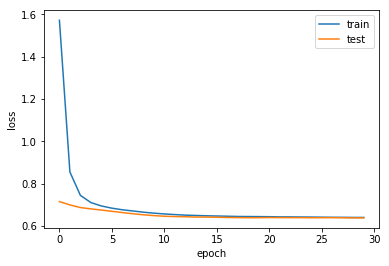

acc:
0.6064963888097532
val_acc:
0.6024251405312117


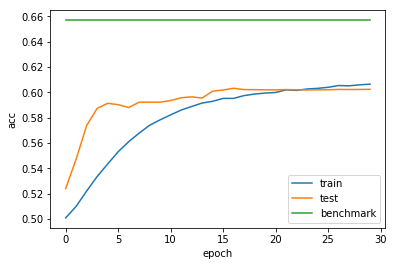

(148335, 1)
finish dataread
(None, 7, 1, 10)
(None, 7, 1, 8)
(None, 7, 1, 18)
g_MLP
drop_out
compile model success
13
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: size=7888 MiB, count=182, average=43.3 MiB
(1025640, 144, 7)
(1025640, 7, 144, 1)
[Training model......]
Train on 749910 samples, validate on 263634 samples
Epoch 1/30
749910/749910 [==============================] - 30s 40us/step - loss: 1.3193 - acc: 0.5062 - val_loss: 0.7125 - val_acc: 0.5262
Epoch 2/30
749910/749910 [==============================] - 17s 22us/step - loss: 0.8110 - acc: 0.5145 - val_loss: 0.6860 - val_acc: 0.5542
Epoch 3/30
749910/749910 [==============================] - 17s 22us/step - loss: 0.7228 - acc: 0.5317 - val_loss: 0.6764 - val_acc: 0.5863
Epoch 4/30
749910/749910 [==============================] - 17s 22us/step - loss: 0.6932 - acc: 0.5471 - val_loss: 0.6645 - val_acc: 0.5960
Epoch 5/30
749910/749910 [==============================] - 17s 22us/step - loss: 0.6758 - a

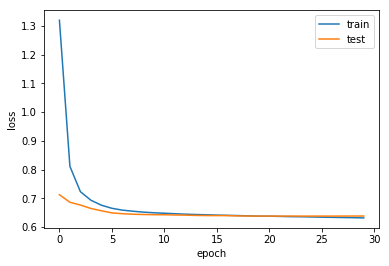

acc:
0.6126561854125719
val_acc:
0.5991715787064191


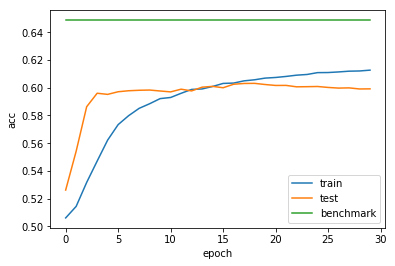

(148335, 1)
finish dataread
(None, 7, 1, 10)
(None, 7, 1, 8)
(None, 7, 1, 18)
g_MLP
drop_out
compile model success
14
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: size=8079 MiB, count=183, average=44.2 MiB
(1050588, 144, 7)
(1050588, 7, 144, 1)
[Training model......]
Train on 784476 samples, validate on 254016 samples
Epoch 1/30
784476/784476 [==============================] - 30s 39us/step - loss: 1.6502 - acc: 0.5006 - val_loss: 0.7382 - val_acc: 0.4934
Epoch 2/30
784476/784476 [==============================] - 17s 22us/step - loss: 0.8533 - acc: 0.5053 - val_loss: 0.7022 - val_acc: 0.5021
Epoch 3/30
784476/784476 [==============================] - 17s 22us/step - loss: 0.7418 - acc: 0.5162 - val_loss: 0.6910 - val_acc: 0.5447
Epoch 4/30
784476/784476 [==============================] - 17s 22us/step - loss: 0.7094 - acc: 0.5268 - val_loss: 0.6823 - val_acc: 0.5719
Epoch 5/30
784476/784476 [==============================] - 17s 22us/step - loss: 0.6924 - a

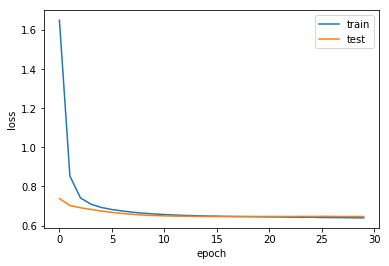

acc:
0.6088382564006208
val_acc:
0.5882975875535399


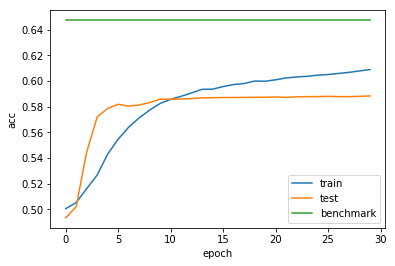

(148335, 1)
finish dataread
(None, 7, 1, 10)
(None, 7, 1, 8)
(None, 7, 1, 18)
g_MLP
drop_out
compile model success
15
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: size=7896 MiB, count=184, average=42.9 MiB
(1026690, 144, 7)
(1026690, 7, 144, 1)
[Training model......]
Train on 772674 samples, validate on 241920 samples
Epoch 1/30
772674/772674 [==============================] - 31s 40us/step - loss: 2.3194 - acc: 0.5060 - val_loss: 0.7261 - val_acc: 0.5335
Epoch 2/30
772674/772674 [==============================] - 17s 22us/step - loss: 1.0115 - acc: 0.5091 - val_loss: 0.6884 - val_acc: 0.5638
Epoch 3/30
772674/772674 [==============================] - 17s 22us/step - loss: 0.7882 - acc: 0.5172 - val_loss: 0.6830 - val_acc: 0.5772
Epoch 4/30
772674/772674 [==============================] - 17s 22us/step - loss: 0.7276 - acc: 0.5243 - val_loss: 0.6821 - val_acc: 0.5688
Epoch 5/30
772674/772674 [==============================] - 17s 22us/step - loss: 0.7029 - a

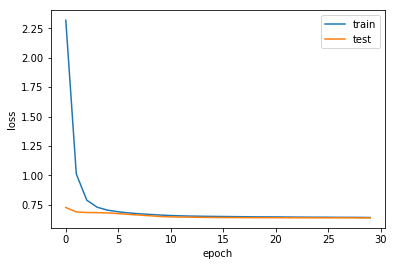

acc:
0.6058337668137973
val_acc:
0.5989955357142858


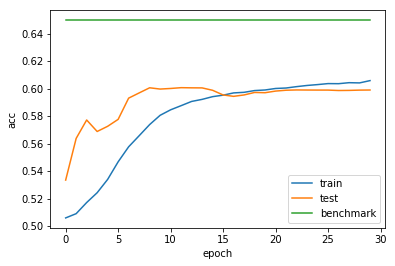

(148335, 1)
finish dataread
(None, 7, 1, 10)
(None, 7, 1, 8)
(None, 7, 1, 18)
g_MLP
drop_out
compile model success
16
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: size=8167 MiB, count=184, average=44.4 MiB
(1061970, 144, 7)
(1061970, 7, 144, 1)
[Training model......]
Train on 783762 samples, validate on 266112 samples
Epoch 1/30
783762/783762 [==============================] - 33s 42us/step - loss: 1.4538 - acc: 0.4957 - val_loss: 0.7134 - val_acc: 0.5319
Epoch 2/30
783762/783762 [==============================] - 18s 22us/step - loss: 0.8341 - acc: 0.5083 - val_loss: 0.7104 - val_acc: 0.5238
Epoch 3/30
783762/783762 [==============================] - 18s 22us/step - loss: 0.7421 - acc: 0.5207 - val_loss: 0.7002 - val_acc: 0.5615
Epoch 4/30
783762/783762 [==============================] - 18s 22us/step - loss: 0.7087 - acc: 0.5352 - val_loss: 0.6913 - val_acc: 0.5629
Epoch 5/30
783762/783762 [==============================] - 18s 22us/step - loss: 0.6923 - a

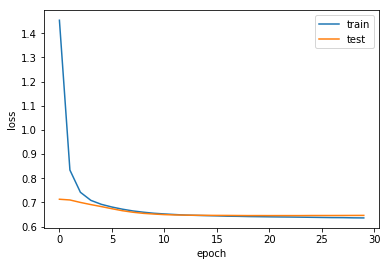

acc:
0.6117303467487465
val_acc:
0.5919838260721277


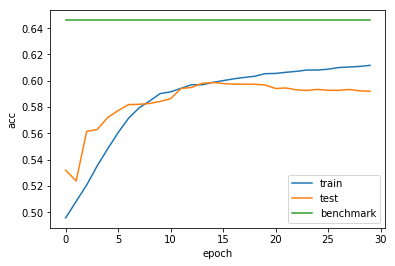

(148335, 1)
finish dataread
(None, 7, 1, 10)
(None, 7, 1, 8)
(None, 7, 1, 18)
g_MLP
drop_out
compile model success
17
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: size=8019 MiB, count=184, average=43.6 MiB
(1042734, 144, 7)
(1042734, 7, 144, 1)
[Training model......]
Train on 786240 samples, validate on 244398 samples
Epoch 1/30
786240/786240 [==============================] - 33s 42us/step - loss: 1.7415 - acc: 0.5038 - val_loss: 0.7018 - val_acc: 0.5595
Epoch 2/30
786240/786240 [==============================] - 17s 22us/step - loss: 0.8814 - acc: 0.5178 - val_loss: 0.6827 - val_acc: 0.5834
Epoch 3/30
786240/786240 [==============================] - 17s 22us/step - loss: 0.7375 - acc: 0.5368 - val_loss: 0.6769 - val_acc: 0.5891
Epoch 4/30
786240/786240 [==============================] - 17s 22us/step - loss: 0.6982 - acc: 0.5520 - val_loss: 0.6723 - val_acc: 0.5908
Epoch 5/30
786240/786240 [==============================] - 17s 22us/step - loss: 0.6829 - a

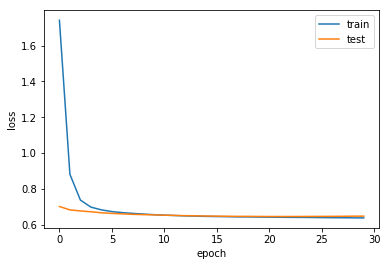

acc:
0.6095378000997265
val_acc:
0.5959418651595225


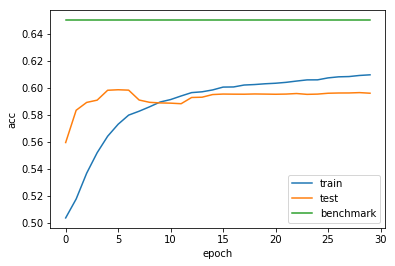

(148335, 1)
finish dataread
(None, 7, 1, 10)
(None, 7, 1, 8)
(None, 7, 1, 18)
g_MLP
drop_out
compile model success
18
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: size=8000 MiB, count=184, average=43.5 MiB
(1040214, 144, 7)
(1040214, 7, 144, 1)
[Training model......]
Train on 776622 samples, validate on 251496 samples
Epoch 1/30
776622/776622 [==============================] - 34s 44us/step - loss: 1.5571 - acc: 0.5062 - val_loss: 0.6925 - val_acc: 0.5380
Epoch 2/30
776622/776622 [==============================] - 17s 23us/step - loss: 0.8276 - acc: 0.5118 - val_loss: 0.6815 - val_acc: 0.5346
Epoch 3/30
776622/776622 [==============================] - 17s 22us/step - loss: 0.7243 - acc: 0.5251 - val_loss: 0.6763 - val_acc: 0.5871
Epoch 4/30
776622/776622 [==============================] - 18s 23us/step - loss: 0.6961 - acc: 0.5410 - val_loss: 0.6719 - val_acc: 0.5834
Epoch 5/30
776622/776622 [==============================] - 18s 23us/step - loss: 0.6827 - a

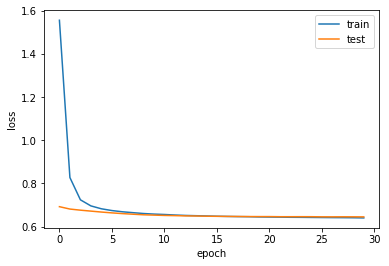

acc:
0.6070482164996577
val_acc:
0.5911386263900636


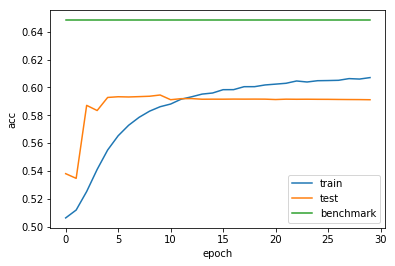

(148335, 1)
finish dataread
(None, 7, 1, 10)
(None, 7, 1, 8)
(None, 7, 1, 18)
g_MLP
drop_out
compile model success
19
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: size=8087 MiB, count=187, average=43.2 MiB
(1051554, 144, 7)
(1051554, 7, 144, 1)
[Training model......]
Train on 786198 samples, validate on 253260 samples
Epoch 1/30
786198/786198 [==============================] - 35s 44us/step - loss: 1.3238 - acc: 0.5064 - val_loss: 0.7101 - val_acc: 0.5366
Epoch 2/30
786198/786198 [==============================] - 18s 22us/step - loss: 0.8036 - acc: 0.5208 - val_loss: 0.6870 - val_acc: 0.5644
Epoch 3/30
786198/786198 [==============================] - 18s 22us/step - loss: 0.7279 - acc: 0.5320 - val_loss: 0.6797 - val_acc: 0.5689
Epoch 4/30
786198/786198 [==============================] - 18s 22us/step - loss: 0.7014 - acc: 0.5422 - val_loss: 0.6736 - val_acc: 0.5711
Epoch 5/30
786198/786198 [==============================] - 18s 22us/step - loss: 0.6867 - a

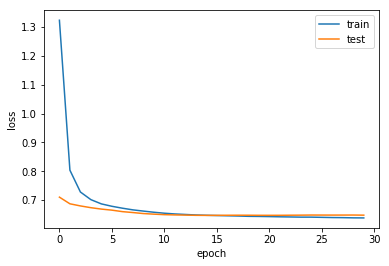

acc:
0.610571382778101
val_acc:
0.5993524441469208


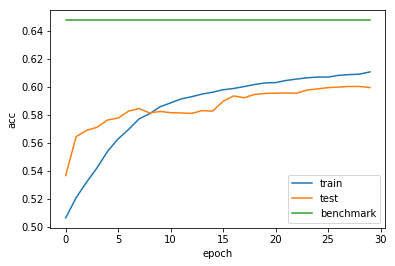

In [8]:

#model.summary()

for z in range(head,tail,1):
    """
     V
    """
    n=daynum[tail]-daynum[head]
    df = pd.read_csv('JPY_data_ver2.0.csv',header=None)  # 讀取訓練數據
    print(df.shape)  
    jpy5months = np.zeros(n)
    dt=0
    for i in range(daynum[head],daynum[tail],1):
        jpy5months[dt] = df[0][i]  
        dt=dt+1
    df = pd.read_csv('EUR_data_ver2.0.csv',header=None)  # 讀取訓練數據
    eur5months = np.zeros(n)
    dt=0
    for i in range(daynum[head],daynum[tail],1):
        eur5months[dt] = df[0][i]  
        dt=dt+1
    df = pd.read_csv('AUD_data_ver2.0.csv',header=None)  # 讀取訓練數據
    aud5months = np.zeros(n)
    dt=0
    for i in range(daynum[head],daynum[tail],1):
        aud5months[dt] = df[0][i]  
        dt=dt+1
    df = pd.read_csv('CHF_data_ver2.0.csv',header=None)  # 讀取訓練數據
    chf5months = np.zeros(n)
    dt=0
    for i in range(daynum[head],daynum[tail],1):
        chf5months[dt] = df[0][i]  
        dt=dt+1
    df = pd.read_csv('SEK_data_ver2.0.csv',header=None)  # 讀取訓練數據
    sek5months = np.zeros(n)
    dt=0
    for i in range(daynum[head],daynum[tail],1):
        sek5months[dt] = df[0][i]  
        dt=dt+1
    df = pd.read_csv('CAD_data_ver2.0.csv',header=None)  # 讀取訓練數據
    cad5months = np.zeros(n)
    dt=0
    for i in range(daynum[head],daynum[tail],1):
        cad5months[dt] = df[0][i]  
        dt=dt+1
    df = pd.read_csv('GBP_data_ver2.0.csv',header=None)  # 讀取訓練數據
    gbp5months = np.zeros(n)
    dt=0
    for i in range(daynum[head],daynum[tail],1):
        gbp5months[dt] = df[0][i]  
        dt=dt+1
    print('finish dataread')
    Train_data=np.zeros(((n-l+1,len(currency),l)))
    for p in range(n-l+1):
        Train_data[p,0,:]=sek5months[p:p+l]
        Train_data[p,1,:]=chf5months[p:p+l]
        Train_data[p,2,:]=cad5months[p:p+l]
        Train_data[p,3,:]=gbp5months[p:p+l]
        Train_data[p,4,:]=jpy5months[p:p+l]
        Train_data[p,5,:]=eur5months[p:p+l]
        Train_data[p,6,:]=aud5months[p:p+l]       
    MLP_unit=64
    visual_scene = Input((currencynum,l,1))
    visual_conv = ConvolutionNetworks([20,10],[(1,kn),(1,kn)])(visual_scene)
    print(K.int_shape(visual_conv))
    tag = build_tag(visual_conv)
    visual_conv = Concatenate()([tag, visual_conv])
    print(K.int_shape(visual_conv))
    
    shapes = visual_conv.shape
    w = shapes[1]
    f = shapes[2]
    features= []
    #features = np.zeros(0)
    for k1 in range(w):
        for k2 in range(f):
            def get_feature(t):
                return t[:, k1, k2, :]
            #get_feature_layer = Lambda(get_feature)
            features.append(Lambda(get_feature)(visual_conv))
    
      
    input2 = Input((16,))
    onehot_encode_question = input2
    relations = []
    concat = Concatenate()
    for feature1 in features:
        for feature2 in features:
            relations.append(concat([feature1, feature2, onehot_encode_question]))    
    
     
    g_MLP = get_MLP(4, get_dense(4,MLP_unit))
    
    print("g_MLP")
    mid_relations = []
    for r in relations:
        mid_relations.append(g_MLP(r))
    
    combined_relation = Add()(mid_relations)
    
    #f_MLP
    rn = dropout_dense(combined_relation,MLP_unit)
    rn = dropout_dense(rn,MLP_unit)
    print('drop_out')
    
    pred = Dense(1, activation = 'sigmoid')(rn)
    
    
    #model = Model(inputs=[visual_scene])
    model = Model(inputs=[visual_scene, input2, tag], outputs = pred)
    optimizer = Adam(lr = 3e-5)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    print('compile model success')    

    #model.summary()
    print(z)
    fit_show(Train_data,daynum[z],daynum[z+3],daynum[z+4])

train_acc:red,test_acc:blue


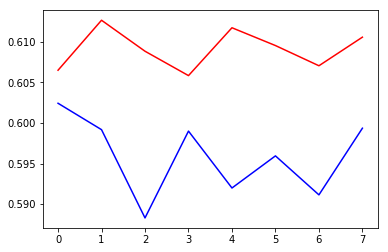

train_loss:red,test_loss:blue


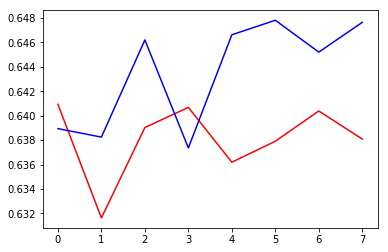

trend:red,vol:blue


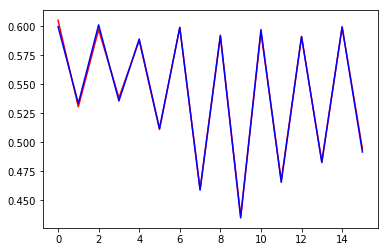

In [9]:
print("train_acc:red,test_acc:blue")    
plt.plot(lastepoch_train_acc,color='r')
plt.plot(lastepoch_test_acc,color='b')
plt.show()
print("train_loss:red,test_loss:blue")
plt.plot(lastepoch_train_loss,color='r')
plt.plot(lastepoch_test_loss,color='b')
plt.show()
print("trend:red,vol:blue")
plt.plot(total_test_trend,color='r')
plt.plot(total_test_vol,color='b')
plt.show()

In [110]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           (None, 7, 36, 1)     0                                            
__________________________________________________________________________________________________
conv2d_27 (Conv2D)              (None, 7, 32, 20)    120         input_16[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_21 (MaxPooling2D) (None, 7, 8, 20)     0           conv2d_27[0][0]                  
__________________________________________________________________________________________________
batch_normalization_15 (BatchNo (None, 7, 8, 20)     80          max_pooling2d_21[0][0]           
__________________________________________________________________________________________________
conv2d_28 